Copyright **`(c)`** 2022 Giovanni Squillero `<squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free for personal or classroom use; see [`LICENSE.md`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  


# Lab 3: ES

## Task

Write agents able to play [*Nim*](https://en.wikipedia.org/wiki/Nim), with an arbitrary number of rows and an upper bound $k$ on the number of objects that can be removed in a turn (a.k.a., *subtraction game*).

The goal of the game is to **avoid** taking the last object.

* Task2.1: An agent using fixed rules based on *nim-sum* (i.e., an *expert system*)
* Task2.2: An agent using evolved rules using ES

## Instructions

* Create the directory `lab2` inside the course repo 
* Put a `README.md` and your solution (all the files, code and auxiliary data if needed)

## Notes

* Working in group is not only allowed, but recommended (see: [Ubuntu](https://en.wikipedia.org/wiki/Ubuntu_philosophy) and [Cooperative Learning](https://files.eric.ed.gov/fulltext/EJ1096789.pdf)). Collaborations must be explicitly declared in the `README.md`.
* [Yanking](https://www.emacswiki.org/emacs/KillingAndYanking) from the internet is allowed, but sources must be explicitly declared in the `README.md`.



In [430]:
import inspect
import logging
import random

import numpy as np

from pprint import pprint, pformat
from collections import namedtuple
from copy import deepcopy
from matplotlib import pyplot as plt
from tqdm import tqdm

## The *Nim* and *Nimply* classes

In [431]:
Nimply = namedtuple("Nimply", "row, num_objects")


In [432]:
class Nim:
    def __init__(self, num_rows: int, k: int = None) -> None:
        self._rows = [i * 2 + 1 for i in range(num_rows)]
        self._k = k

    def __bool__(self):
        return sum(self._rows) > 0

    def __str__(self):
        return "<" + " ".join(str(_) for _ in self._rows) + ">"

    @property
    def rows(self) -> tuple:
        return tuple(self._rows)

    def nimming(self, ply: Nimply) -> None:
        row, num_objects = ply
        assert self._rows[row] >= num_objects
        assert self._k is None or num_objects <= self._k
        self._rows[row] -= num_objects


## Sample (and silly) startegies 

In [433]:
def pure_random(state: Nim) -> Nimply:
    """A completely random move"""
    row = random.choice([r for r, c in enumerate(state.rows) if c > 0])
    num_objects = random.randint(1, state.rows[row])
    return Nimply(row, num_objects)


In [434]:
def gabriele(state: Nim) -> Nimply:
    """Pick always the maximum possible number of the lowest row"""
    possible_moves = [(r, o) for r, c in enumerate(state.rows) for o in range(1, c + 1)]
    return Nimply(*max(possible_moves, key=lambda m: (-m[0], m[1])))


In [435]:
def adaptive(state: Nim) -> Nimply:
    """A strategy that can adapt its parameters"""
    genome = {"love_small": 0.5}


In [436]:
def nim_sum(state: Nim) -> int:
    tmp = np.array([tuple(int(x) for x in f"{c:032b}") for c in state.rows])
    xor = tmp.sum(axis=0) % 2
    return int("".join(str(_) for _ in xor), base=2)


def analize(raw: Nim) -> dict:
    cooked = dict()
    cooked["possible_moves"] = dict()
    for ply in (Nimply(r, o) for r, c in enumerate(raw.rows) for o in range(1, c + 1)):
        tmp = deepcopy(raw)
        tmp.nimming(ply)
        cooked["possible_moves"][ply] = nim_sum(tmp)
    return cooked


def optimal(state: Nim) -> Nimply:
    analysis = analize(state)
    logging.debug(f"analysis:\n{pformat(analysis)}")
    spicy_moves = [ply for ply, ns in analysis["possible_moves"].items() if ns != 0]
    if not spicy_moves:
        spicy_moves = list(analysis["possible_moves"].keys())
    ply = random.choice(spicy_moves)
    return ply


## Oversimplified match

In [437]:
logging.getLogger().setLevel(logging.INFO)

strategy = (optimal, pure_random)

nim = Nim(5)
logging.info(f"init : {nim}")
player = 0
while nim:
    ply = strategy[player](nim)
    logging.info(f"ply: player {player} plays {ply}")
    nim.nimming(ply)
    logging.info(f"status: {nim}")
    player = 1 - player
logging.info(f"status: Player {player} won!")


INFO:root:init : <1 3 5 7 9>
INFO:root:ply: player 0 plays Nimply(row=3, num_objects=4)
INFO:root:status: <1 3 5 3 9>
INFO:root:ply: player 1 plays Nimply(row=0, num_objects=1)
INFO:root:status: <0 3 5 3 9>
INFO:root:ply: player 0 plays Nimply(row=4, num_objects=8)
INFO:root:status: <0 3 5 3 1>
INFO:root:ply: player 1 plays Nimply(row=2, num_objects=4)
INFO:root:status: <0 3 1 3 1>
INFO:root:ply: player 0 plays Nimply(row=2, num_objects=1)
INFO:root:status: <0 3 0 3 1>
INFO:root:ply: player 1 plays Nimply(row=4, num_objects=1)
INFO:root:status: <0 3 0 3 0>
INFO:root:ply: player 0 plays Nimply(row=3, num_objects=3)
INFO:root:status: <0 3 0 0 0>
INFO:root:ply: player 1 plays Nimply(row=1, num_objects=1)
INFO:root:status: <0 2 0 0 0>
INFO:root:ply: player 0 plays Nimply(row=1, num_objects=1)
INFO:root:status: <0 1 0 0 0>
INFO:root:ply: player 1 plays Nimply(row=1, num_objects=1)
INFO:root:status: <0 0 0 0 0>
INFO:root:status: Player 0 won!


## Evolutionary approach

In [438]:
NUM_ROWS = 5
NUM_RULES = 15
POPULATION_SIZE = 10
OFFSPRING_SIZE = 40
TOURNAMENT_SIZE = 2
MUTATION_PROBABILITY = 0.15
GAMES_PER_AGENT = 50

In [439]:
from typing import Callable


class Rule:
    def __init__(self, condition: Callable, action: Nimply, weight):
        self.condition = condition
        self.action = action
        self.weight = weight

    def update_weight(self, positive: bool):
        if positive:
            self.weight = min(1, self.weight * 1.1)
        else:
            self.weight /= 1.1
    
    # Set weight of unfeasible rules to 0
    def slash(self):
        self.weight = 0


class NimAgent:
    def __init__(self, rules: list[Rule]):
        self._rules = rules
        self._played = 0
        self._won = 0

    def get_rules(self) -> list[Rule]:
        return self._rules

    def make_move(self, state: Nim) -> Nimply:
        for i, rule in enumerate(self._rules):
            # Verify if the condition is valid or not and if it's unfeasible, slash its weight
            if state.rows[rule.action.row] >= rule.action.num_objects:
                new_state = deepcopy(state)
                new_state.nimming(rule.action)
    
                if rule.condition(new_state):
                    return rule.action
                
            # To slash rule, first check that is globally unfeasible and not only for the current turn
            elif state.rows[rule.action.row] == ((rule.action.row + 1) * 2 - 1) and rule.weight != 0:
                rule.slash()

        # in case none of the rules of the agent matches, then go random
        return pure_random(state)

    def played(self, won: bool) -> None:
        if won:
            self._won += 1
        
        for weight in self._rules:
            weight.update_weight(won)
        
        self._played += 1
    
    def reset_fitness(self):
        self._won = self._played = 0
    
    def fitness(self) -> float:
        if self._played != 0:
            return self._won / self._played
        else:
            return 0

In [440]:
# generate a set of "almost" random conditions
def define_conditions():
    conditions = []

    # num_elements_conditions
    for row in range(NUM_ROWS):
        for elem in range((NUM_ROWS + 1) * 2 - 1):
            conditions.append(lambda state: state.rows[row] >= elem)
            conditions.append(lambda state: state.rows[row] < elem)

    # odd_elem_conditions
    for row in range(NUM_ROWS):
        conditions.append(lambda state: state.rows[row] % 2 == 1)
        conditions.append(lambda state: state.rows[row] % 2 == 0)

    # sum_elem_conditions
    conditions.append(lambda state: sum(state.rows) % 2 == 1)
    conditions.append(lambda state: sum(state.rows) % 2 == 0)
    conditions.append(lambda state: sum(state.rows) < NUM_ROWS ** 2 // 2)

    # other
    conditions.append(lambda state: np.sum(np.array(state.rows) == 0) > 2)
    conditions.append(lambda state: np.sum(np.array(state.rows) == 0) <= 2)

    # nim_sum
    # conditions.append(lambda state: nim_sum(state) != 0)
    
    return conditions

def define_moves(state: Nim) -> list:
    moves = []
    for ply in (Nimply(r, o) for r, c in enumerate(state.rows) for o in range(1, c + 1)):
        moves.append(ply)
    return moves


def generate_rules(conditions: list, moves: list):
    rules = []
    for condition in conditions:
        for move in moves:
            # generate rule with a fixed weight
            rules.append(Rule(condition, move, 0.5))

    return rules


def initialize_population(rules: list) -> list[NimAgent]:
    population = []

    for _ in range(POPULATION_SIZE):
        individual_rules = []

        for _ in range(NUM_RULES):
            # get a random rule
            rule = random.choice(rules)
            individual_rules.append(rule)

        population.append(NimAgent(individual_rules))

    return population

In [441]:
conditions = define_conditions()
moves = define_moves(Nim(NUM_ROWS))
rules = generate_rules(conditions, moves)
initial_population = initialize_population(rules)

In [442]:
def parent_selection(population: list[NimAgent]) -> NimAgent:
    chosen_agents = [random.choice(population) for _ in range(TOURNAMENT_SIZE)]

    best_parent = None
    best_parent_fitness = None

    for agent in chosen_agents:
        cur_parent_fitness = agent.fitness()

        if best_parent_fitness is None or cur_parent_fitness < best_parent_fitness:
            best_parent_fitness = cur_parent_fitness
            best_parent = agent

    return best_parent


def mutate(agent: NimAgent) -> NimAgent:
    new_rules = deepcopy(agent.get_rules())
    rule_to_be_changed_idx = random.randint(0, NUM_RULES - 1)
    # random choice but weighted according to the rules weights
    new_rule = random.choices(rules, weights=[rule.weight + 0.001 for rule in rules], k=1)[0]
    new_rules[rule_to_be_changed_idx] = new_rule
    return NimAgent(new_rules)


def crossover(agent1: NimAgent, agent2: NimAgent) -> NimAgent:
    rules1 = agent1.get_rules()
    rules2 = agent2.get_rules()
    
    # Uniform crossover
    new_rules = []
    for i in range(NUM_RULES):
        # random choice but weighted according to the rules weights
        new_rules.append(random.choices([rules1[i], rules2[i]], weights=[rule.weight + 0.001 for rule in [rules1[i], rules2[i]]], k=1)[0])
    
    return NimAgent(new_rules)

In [443]:
def evaluate_agent(agent: NimAgent) -> None:
    for game in range(GAMES_PER_AGENT):
        # Remove the bias given by playing a lot of games consequently against the same opponent
        strategy_opponent = random.choices([pure_random, gabriele, optimal], weights=[0.3, 0.2, 0.5], k=1)[0]
        strategy = (strategy_opponent, agent.make_move)
            
        nim = Nim(NUM_ROWS)
        player = 0
        while nim:
            ply = strategy[player](nim)
            nim.nimming(ply)
            player = 1 - player
        
        if player == 1:
            agent.played(won=True)
        else:
            agent.played(won=False)

In [444]:
def evolutionary_strategy(population: list[NimAgent]) -> list[NimAgent]:
    offspring = []

    for counter in range(OFFSPRING_SIZE):
        if random.random() < MUTATION_PROBABILITY:
            # mutation
            a = parent_selection(population)
            o = mutate(a)
        else:
            # crossover
            a1 = parent_selection(population)
            a2 = parent_selection(population)
            o = crossover(a1, a2)
        evaluate_agent(o)
        offspring.append(o)

    population.extend(offspring)
    population.sort(key=lambda agent: agent.fitness(), reverse=True)
    taken = population[:POPULATION_SIZE]

    return taken

100%|██████████| 300/300 [19:42<00:00,  3.94s/it]


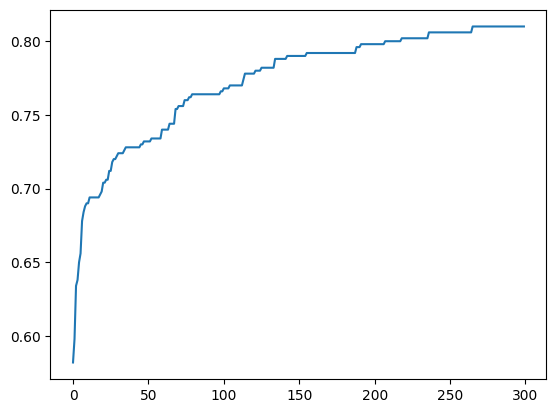

In [445]:
EPOCHS = 500

population = initial_population
for agent in population:
    evaluate_agent(agent)

avg_fitnesses = []
for _ in tqdm(range(EPOCHS)):
    # print(f"Running epoch {_}")
    new_population = evolutionary_strategy(population)
    avg_fitness = np.average([agent.fitness() for agent in new_population])
    # print(f"\tAverage fitness: {avg_fitness}")
    avg_fitnesses.append(avg_fitness)
    population = new_population

plt.plot(range(EPOCHS), avg_fitnesses)
plt.show()

In [446]:
for i, agent in enumerate(population):
    agent.reset_fitness()
    for _ in range(GAMES_PER_AGENT):
        strategy = (optimal, agent.make_move)
        
        nim = Nim(NUM_ROWS)
        player = 0
        while nim:
            ply = strategy[player](nim)
            nim.nimming(ply)
            player = 1 - player
        
        if player == 1:
            agent.played(won=True)
        else:
            agent.played(won=False)
    
    print(f"Agent {i} won: {int(agent.fitness() * GAMES_PER_AGENT)}/{GAMES_PER_AGENT}")

Agent 0 won: 28/50
Agent 1 won: 16/50
Agent 2 won: 23/50
Agent 3 won: 23/50
Agent 4 won: 20/50
Agent 5 won: 24/50
Agent 6 won: 27/50
Agent 7 won: 19/50
Agent 8 won: 27/50
Agent 9 won: 22/50


In [447]:
all_rules = rules
all_rules.sort(key=lambda rule: rule.weight, reverse=True)

best_rules = all_rules[:NUM_RULES]
for rule in best_rules:
    print(f"Condition: {inspect.getsource(rule.condition)}, action: {rule.action}, weight: {rule.weight}")
    
best_agent = NimAgent(best_rules)

for game in range(GAMES_PER_AGENT):
    strategy = (optimal, best_agent.make_move)
    
    nim = Nim(NUM_ROWS)
    player = 0
    while nim:
        ply = strategy[player](nim)
        nim.nimming(ply)
        player = 1 - player
    
    if player == 1:
        best_agent.played(won=True)
    else:
        best_agent.played(won=False)

print(f"Best agent won: {int(best_agent.fitness() * GAMES_PER_AGENT)}/{GAMES_PER_AGENT}")

Condition:             conditions.append(lambda state: state.rows[row] >= elem)
, action: Nimply(row=2, num_objects=2), weight: 1
Condition:             conditions.append(lambda state: state.rows[row] >= elem)
, action: Nimply(row=4, num_objects=4), weight: 1
Condition:             conditions.append(lambda state: state.rows[row] >= elem)
, action: Nimply(row=4, num_objects=8), weight: 1
Condition:             conditions.append(lambda state: state.rows[row] < elem)
, action: Nimply(row=4, num_objects=3), weight: 1
Condition:             conditions.append(lambda state: state.rows[row] >= elem)
, action: Nimply(row=1, num_objects=3), weight: 1
Condition:             conditions.append(lambda state: state.rows[row] >= elem)
, action: Nimply(row=3, num_objects=2), weight: 1
Condition:             conditions.append(lambda state: state.rows[row] >= elem)
, action: Nimply(row=3, num_objects=4), weight: 1
Condition:             conditions.append(lambda state: state.rows[row] >= elem)
, action: N